# 5.2 Semantic Labeling
### Initial considerations:
- labled dataset: 50 images
- image size: 640 x 512
- classes 11 (10 + null class)
- available local computational recourses: Acer Aspire (RAM: 8G, CPU: Intel core i5 7th Gen, GPU: Nvidia Geforce 940mx 2G)

### approach:
Expand the dataset with basic augmentation techniques: zoom, flip, shift, brightness...
Explore possible rgb segmentation models keeping in mind robustness, efficiency, accuracy and prediction time.
Train the model with the augmented data
Evaluate Model performance

Auxiliar functions for (plotting, showing images...) can be found in the 'semantic_utils.py' file attached in the appendix

In [ ]:
import numpy as np
import keras as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
import matplotlib.pyplot as plt;
from sklearn.model_selection import train_test_split
;

### Load Data

In [2]:
# Considering computational restrictions, all the images had their dimentions reduced by a factor of 2
image_width, image_height,channels = int(640/2),int(512/2),4
output_width=160
output_height=128

rgb_path = 'ml_task/left'
labeled_path = 'ml_task/labeled'
depth_path = 'ml_task/disp'

from random import shuffle

file_names = os.listdir(labeled_path) #list of images's file names
shuffle(file_names)

X = np.zeros(shape=(len(file_names),image_height, image_width, channels),dtype=np.float32) #data
Y = np.zeros(shape=(len(file_names),image_height, image_width, 1),dtype=np.float32)        #labels

for i,f in enumerate(file_names):  #iterate through each file
    image_name = f[:4] #image number
    img_x = load_img(rgb_path+'/'+image_name+'_left.jpg')   #read rgb image
    img_y = load_img(labeled_path+'/'+f)                    #read labeled image
    img_d = load_img(depth_path+'/'+image_name+'_disp.png') #read depth image
    
    img_x.thumbnail((image_width, image_height)) #resize images
    img_y.thumbnail((image_width, image_height))
    img_d.thumbnail((image_width, image_height))

    # Convert to Numpy Array    
    x = img_to_array(img_x) 
    y = img_to_array(img_y)[:,:,0].astype(np.uint8) #only integers (classes)
    d = img_to_array(img_d)[:,:,0]
        
    X[i,:,:,:3] = x #first 3 channels are RGB
    X[i,:,:,3] = d  #last one is depth
    Y[i,:,:,0] = y

Y[Y>10] = 0


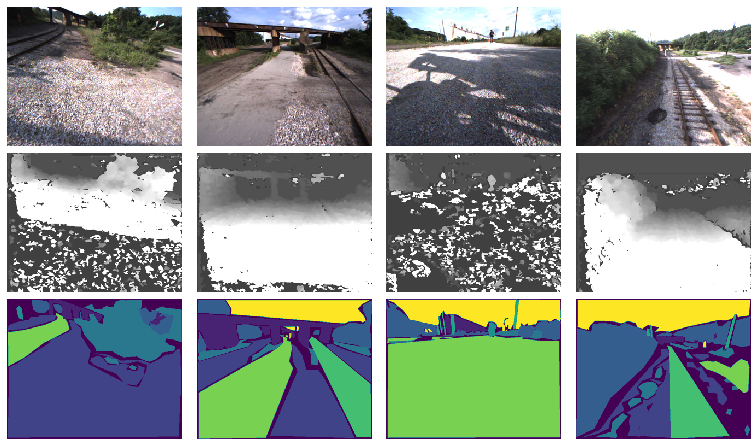

In [3]:
#show dataset
def show_imgs(imgs_array,cols=4,value_min=None,value_max=None,cmap=None):
    """display random images from x image arrays with commun index
    imgs_array: list with x numpy arrays with shape = (n,None,None,None)
    cols: colunms displayed
    value_min: list with the minimun pixel value to be displayed
    value_max: list with the maximun pixel value to be displayed
    cmap: list of cmap string, default = None"""
    
    fig=plt.figure(figsize=(13, len(imgs_array)*2))
    fig.clf() #clear content
    
    plt.subplots_adjust(left=0.1, bottom=0.0,top=1.0, wspace=0.05, hspace=0.05)
    
    min_index = min([i.shape[0] for i in imgs_array]) #
    random_index = list(np.random.choice(min_index, cols, replace=False)) #list with 'cols' unique index values
    
    for j,i in enumerate(random_index):
        for k,img_array in enumerate(imgs_array):
            ax = fig.add_subplot(len(imgs_array),cols,j+k*cols+1)
            ax.axis("off")
            vmax = np.max(img_array) if value_max is None else value_max[k]
            vmin = np.min(img_array) if value_min is None else value_min[k]
            cmap_ = None if cmap is None else cmap[k]
            
            if img_array.shape[3] == 1:
                ax.imshow((img_array[i,:,:,0]).astype(np.uint8),cmap=cmap_, vmin=vmin, vmax=vmax)
            else:
                ax.imshow((img_array[i,:,:,:3]).astype(np.uint8),cmap=cmap_, vmin=vmin, vmax=vmax)
            
    plt.show()
show_imgs([X,X[:,:,:,3:4],Y],value_min = [0,0,0],value_max = [255,255,10],cmap=[None,'gray',None])

# Data augmentation


In [4]:

def combine_generator(gen_x, gen_y, output_width=160, output_height=128, classes=11):
    while True:
        y = next(gen_y)
        y_resized = np.ndarray(shape=(y.shape[0],output_height,output_width))
        for i in range(y.shape[0]):
            y_resized[i,:,:] = cv2.resize(y[i,:,:,0], (output_width, output_height),
                                                    interpolation=cv2.INTER_NEAREST)
            
        # convert to onve hot encoding
        y_onehot = np.zeros((y.shape[0],output_height, output_width, classes))
        for c in range(classes):
            y_onehot[: ,:, :, c] = (y_resized == c).astype(int)

        #reshape label images to flat arrays
        y_flat = np.reshape(y_onehot, (y.shape[0],output_width*output_height, classes))
            
        x = next(gen_x)
        #subtract the mean values of each channel based on image net dataset values
        x[:,:,:,0] -= 103.939
        x[:,:,:,1] -= 116.779
        x[:,:,:,2] -= 123.68
#         x = x[:,:,:,::-1]
        yield(x, y_flat)

def train_gen(X_,Y_):
    """generate images for training"""
    train_img_dg = ImageDataGenerator(brightness_range=[0.2,1.0],
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.3,
                                        shear_range=0.2,
                                        horizontal_flip=True)
    train_mask_dg = ImageDataGenerator(width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.3,
                                        shear_range=0.2,
                                        horizontal_flip=True)
    seed = 1
    train_img_dg.fit(X_)
    train_mask_dg.fit(Y_)

    dgdx_train = train_img_dg.flow(X_, batch_size=1,seed=seed)
    dgdy_train = train_mask_dg.flow(Y_, batch_size=1,seed =seed)
    

    return combine_generator(dgdx_train,dgdy_train)

def val_gen(X_, Y_):
    """generate images for testing"""
    
    seed = 1
    val_img_dg = ImageDataGenerator( horizontal_flip=True) # only flips horizontaly
    val_mask_dg = ImageDataGenerator( horizontal_flip=True )
    
    val_img_dg.fit(X_)
    val_mask_dg.fit(Y_)
    
    dgdx_val = test_img_dg.flow(X_, batch_size=1,seed=seed)
    dgdy_val = test_mask_dg.flow(Y_, batch_size=1,seed =seed)
    
    return combine_generator(dgdx_val,dgdy_val)
def test_gen(X_, Y_):
    """generate images for testing"""
    
    seed = 1
    test_img_dg = ImageDataGenerator( horizontal_flip=False) # dont modify the image
    test_mask_dg = ImageDataGenerator( horizontal_flip=False )
    
    test_img_dg.fit(X_)
    test_mask_dg.fit(Y_)
    
    dgdx_test = test_img_dg.flow(X_, batch_size=1,seed=seed)
    dgdy_test = test_mask_dg.flow(Y_, batch_size=1,seed =seed)
    
    return combine_generator(dgdx_test,dgdy_test)

x,y = next(train_gen(X[:,:,:,:3],Y))
print(x.shape,y.shape)


(1, 256, 320, 3) (1, 20480, 11)


# VGG_unet
Unet using vgg16 model as encoder with pretrained weights on imagenet dataset

In [5]:
from keras_segmentation.models.unet import vgg_unet

In [6]:
def get_model():
    model = vgg_unet(n_classes=11 ,  input_height=image_height,input_width=image_width  )   #with imagenet weghts
    model.compile(loss='categorical_crossentropy',optimizer='adadelta', metrics=['accuracy'])
    model.name = 'vgg_unet'
    return model

In [8]:
# from IPython.display import SVG
# from keras.utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))
model = get_model()
model.summary()










__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 320, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 160, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
b

In [10]:
# Reset Keras Session

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc

def reset_keras(): #https://github.com/keras-team/keras/issues/12625
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
    gc.collect()
    
    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras


## Training / Kfold Cross validation

In [11]:
k = 4 #number of folds

#list of indexes from 0 to 49 in a random order
arr = np.arange(X.shape[0]) 
np.random.shuffle(arr)
fold_size = X.shape[0]/k

H = [] # list to store the train history

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


for fold in range(k):
    reset_keras() #clear the memory to avoid "Resource exhausted"
    
    test_indexes = np.logical_and(arr>=fold_size*fold,arr<fold_size*(fold+1))
    train_indexes = np.logical_not(test_indexes) 
    print("------------ Fold ",fold,"-------------")

    model =  get_model()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')
    checkpoint_callback = ModelCheckpoint(model.name+'/'+model.name+'2_'+str(fold)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    
    h = model.fit_generator(train_gen(X[train_indexes,:,:,:3],Y[train_indexes]),
                            samples_per_epoch=256,
                            validation_data=test_gen(X[test_indexes,:,:,:3],Y[test_indexes]),
                            validation_steps=100,
                            epochs=20,
                            callbacks=[early_stopping, checkpoint_callback])
    H.append(h)
    

------------ Fold  0 -------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=100, epochs=20, callbacks=[<keras.ca..., steps_per_epoch=128)`


Epoch 1/20
128/128 [==============================] - 88s 688ms/step - loss: 1.6106 - acc: 0.4028 - val_loss: 1.9192 - val_acc: 0.4769

Epoch 00001: val_loss improved from inf to 1.91920, saving model to vgg_unet/vgg_unet_0.h5
Epoch 2/20
128/128 [==============================] - 69s 536ms/step - loss: 1.2816 - acc: 0.5008 - val_loss: 1.7652 - val_acc: 0.5153

Epoch 00002: val_loss improved from 1.91920 to 1.76518, saving model to vgg_unet/vgg_unet_0.h5
Epoch 3/20
128/128 [==============================] - 69s 537ms/step - loss: 1.1527 - acc: 0.5378 - val_loss: 1.5482 - val_acc: 0.4828

Epoch 00003: val_loss improved from 1.76518 to 1.54815, saving model to vgg_unet/vgg_unet_0.h5
Epoch 4/20
128/128 [==============================] - 69s 537ms/step - loss: 1.0841 - acc: 0.5571 - val_loss: 1.4457 - val_acc: 0.5786

Epoch 00004: val_loss improved from 1.54815 to 1.44568, saving model to vgg_unet/vgg_unet_0.h5
Epoch 5/20
128/128 [==============================] - 69s 538ms/step - loss: 1.0

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=100, epochs=20, callbacks=[<keras.ca..., steps_per_epoch=128)`


Epoch 1/20
128/128 [==============================] - 78s 607ms/step - loss: 1.6013 - acc: 0.4099 - val_loss: 2.4772 - val_acc: 0.3853

Epoch 00001: val_loss improved from inf to 2.47718, saving model to vgg_unet/vgg_unet_1.h5
Epoch 2/20
128/128 [==============================] - 74s 577ms/step - loss: 1.2166 - acc: 0.5246 - val_loss: 2.5030 - val_acc: 0.4035

Epoch 00002: val_loss did not improve from 2.47718
Epoch 3/20
128/128 [==============================] - 76s 591ms/step - loss: 1.1036 - acc: 0.5542 - val_loss: 1.6852 - val_acc: 0.5557

Epoch 00003: val_loss improved from 2.47718 to 1.68524, saving model to vgg_unet/vgg_unet_1.h5
Epoch 4/20
128/128 [==============================] - 74s 578ms/step - loss: 1.0373 - acc: 0.5681 - val_loss: 1.9853 - val_acc: 0.4773

Epoch 00004: val_loss did not improve from 1.68524
Epoch 5/20
128/128 [==============================] - 73s 569ms/step - loss: 1.0089 - acc: 0.5840 - val_loss: 2.1107 - val_acc: 0.4909

Epoch 00005: val_loss did not im

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=100, epochs=20, callbacks=[<keras.ca..., steps_per_epoch=128)`


Epoch 1/20
128/128 [==============================] - 76s 592ms/step - loss: 1.6092 - acc: 0.3871 - val_loss: 2.1620 - val_acc: 0.4333

Epoch 00001: val_loss improved from inf to 2.16202, saving model to vgg_unet/vgg_unet_2.h5
Epoch 2/20
128/128 [==============================] - 73s 567ms/step - loss: 1.2756 - acc: 0.4969 - val_loss: 2.0824 - val_acc: 0.3677

Epoch 00002: val_loss improved from 2.16202 to 2.08244, saving model to vgg_unet/vgg_unet_2.h5
Epoch 3/20
128/128 [==============================] - 70s 550ms/step - loss: 1.1241 - acc: 0.5424 - val_loss: 1.4877 - val_acc: 0.5343

Epoch 00003: val_loss improved from 2.08244 to 1.48766, saving model to vgg_unet/vgg_unet_2.h5
Epoch 4/20
128/128 [==============================] - 74s 581ms/step - loss: 1.0612 - acc: 0.5662 - val_loss: 1.5757 - val_acc: 0.5597

Epoch 00004: val_loss did not improve from 1.48766
Epoch 5/20
128/128 [==============================] - 74s 575ms/step - loss: 1.0425 - acc: 0.5696 - val_loss: 1.7452 - val_a

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=100, epochs=20, callbacks=[<keras.ca..., steps_per_epoch=128)`


Epoch 1/20
128/128 [==============================] - 75s 583ms/step - loss: 1.5608 - acc: 0.4224 - val_loss: 2.3496 - val_acc: 0.3257

Epoch 00001: val_loss improved from inf to 2.34962, saving model to vgg_unet/vgg_unet_3.h5
Epoch 2/20
128/128 [==============================] - 71s 552ms/step - loss: 1.2458 - acc: 0.5152 - val_loss: 1.6403 - val_acc: 0.4932

Epoch 00002: val_loss improved from 2.34962 to 1.64032, saving model to vgg_unet/vgg_unet_3.h5
Epoch 3/20
128/128 [==============================] - 71s 552ms/step - loss: 1.1514 - acc: 0.5297 - val_loss: 1.5911 - val_acc: 0.5447

Epoch 00003: val_loss improved from 1.64032 to 1.59114, saving model to vgg_unet/vgg_unet_3.h5
Epoch 4/20
128/128 [==============================] - 71s 551ms/step - loss: 1.0577 - acc: 0.5725 - val_loss: 1.7309 - val_acc: 0.5150

Epoch 00004: val_loss did not improve from 1.59114
Epoch 5/20
128/128 [==============================] - 71s 556ms/step - loss: 1.0496 - acc: 0.5695 - val_loss: 1.5969 - val_a

## Model Performance

Fold 0: 	 acc:0.667 	 loss:0.799 	 val_acc:0.630 	 val_loss:1.287
Fold 1: 	 acc:0.610 	 loss:0.940 	 val_acc:0.583 	 val_loss:1.461
Fold 2: 	 acc:0.620 	 loss:0.905 	 val_acc:0.655 	 val_loss:1.149
Fold 3: 	 acc:0.669 	 loss:0.797 	 val_acc:0.631 	 val_loss:1.153

Average:	 acc:0.641 	 loss:0.860 	 val_acc:0.625 	 val_loss:1.263


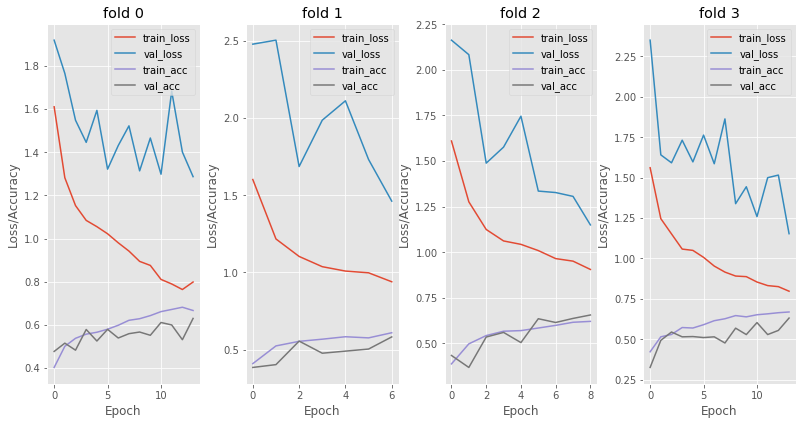

In [145]:
def plot_loss_acc(H,N=None,title="Training Loss and Accuracy on Dataset",ax = plt):
    N_ = len(H.history["loss"])
    if not N is None:
        N_ = min(N,N_)
    
    plt.style.use("ggplot")
    ax.plot(np.arange(0, N_), H.history["loss"][:N_], label="train_loss")
    ax.plot(np.arange(0, N_), H.history["val_loss"][:N_], label="val_loss")
    ax.plot(np.arange(0, N_), H.history["acc"][:N_], label="train_acc")
    ax.plot(np.arange(0, N_), H.history["val_acc"][:N_], label="val_acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")
    
acc = []
loss = []
val_acc = []
val_loss = []
fig=plt.figure(figsize=(13, 5))
plt.subplots_adjust(left=0.1, bottom=0.0,top=1.0, wspace=0.3, hspace=0.2)

for i in range(k):
    ax = fig.add_subplot(1,k,i+1)

    best_epoch = np.argmin(H[i].history["val_loss"])
    
    val_acc.append(H[i].history["val_acc"][best_epoch])
    val_loss.append(H[i].history["val_loss"][best_epoch])
    acc.append(H[i].history["acc"][best_epoch])
    loss.append(H[i].history["loss"][best_epoch])
    
    plot_loss_acc(H[i],N=best_epoch+1,title="fold "+str(i),ax = ax)
    
    print("Fold %d:" % i,"\t acc:%.3f \t loss:%.3f \t val_acc:%.3f \t val_loss:%.3f" % (acc[-1],loss[-1],val_acc[-1],val_loss[-1]))
print("")
print("Average:\t acc:%.3f \t loss:%.3f \t val_acc:%.3f \t val_loss:%.3f" % (np.mean(acc),np.mean(loss),np.mean(val_acc),np.mean(val_loss)))

In [12]:
model = get_model()
model.load_weights('vgg_unet/vgg_unet_3.h5')

In [13]:
def predict(X_,Y_):
    X_cm = []
    y_cm = []
    y_p = []
    for i in range(X_.shape[0]):
        x,y = next(test_gen(np.expand_dims(X_[i],axis=0),np.expand_dims(Y_[i],axis=0)))
        y_p.append(model.predict(x[:,:,:,:3])[0])
        X_cm.append(x[0])
        y_cm.append(y[0])

    X_cm = np.array(X_cm)
    y_cm = np.argmax(np.array(y_cm), axis=2)
    y_pred = np.argmax(np.array(y_p), axis=2)
    return X_, y_cm, y_pred

In [15]:
#predict the test set
X_cm, y_cm, y_pred = predict(X[test_indexes,:,:,:3],Y[test_indexes])

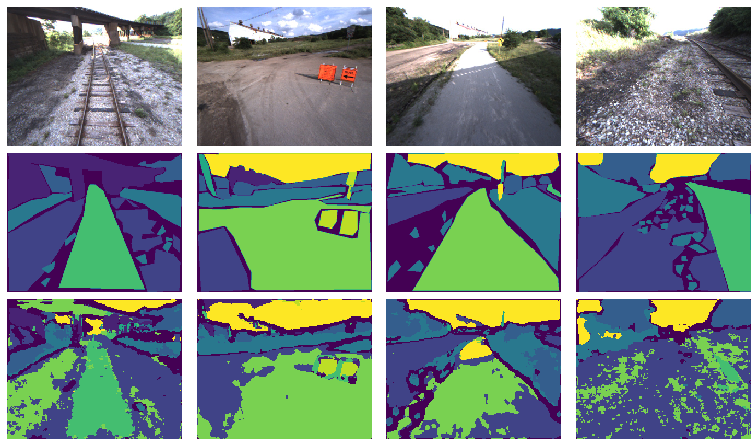

In [23]:
show_imgs([X_cm,np.reshape(y_cm,(y_cm.shape[0],output_height,output_width,1)),np.reshape(y_pred,(y_pred.shape[0],output_height,output_width,1))])

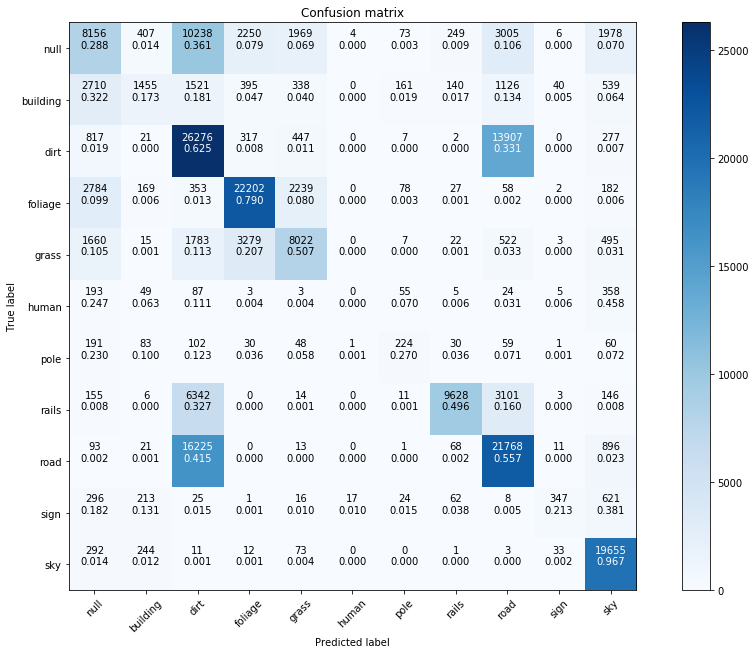

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          normalize = True):

    fig=plt.figure(figsize=(13, 9))
    
    plt.subplots_adjust()
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm_n = cm.astype(np.float32) / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.0f\n%.3f"% (cm[i,j],cm_n[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylim(len(classes)-0.5,-0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()


class_names = { 'null': 0, 'building': 1,'dirt': 2,'foliage': 3,'grass': 4,
               'human': 5,'pole': 6,'rails': 7,'road': 8,'sign': 9,'sky': 10 }

cnf_matrix = confusion_matrix(y_cm.flatten(),y_pred.flatten())

plot_confusion_matrix(cnf_matrix, classes=class_names.keys(),
                      title='Confusion matrix')


The confusion matrix above shows the that one of the main problems that the model faces is to distinguish 'dirt' and 'road' pixels. Also it is possible to notice that the classes 'human', 'pole' and 'grass' are miss represented in the dataset, the histogram bellow also confirm this information.

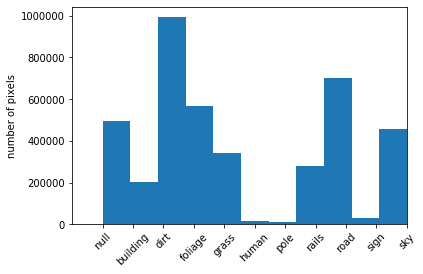

In [24]:
def frequency_hist(X_,classes,title="Frequency Histogram"):
    plt.hist(X_.flatten(), len(classes))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.ylabel('number of pixels')
    plt.xlim(-1,len(classes)-1)
    
    plt.show()
frequency_hist(Y,class_names.keys())